In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 读取数据文件
orders = pd.read_csv('../../python_ml/data/instacart/orders.csv')
order_products = pd.read_csv('../../python_ml/data/instacart/order_products__prior.csv')
products = pd.read_csv('../../python_ml/data/instacart/products.csv')
aisles = pd.read_csv('../../python_ml/data/instacart/aisles.csv')

# 数据合并
# 先合并订单和订单产品
df = pd.merge(orders, order_products, on='order_id', how='inner')

# 再合并产品信息
df = pd.merge(df, products, on='product_id', how='inner')

# 最后合并货架信息
# 合并货架信息并只取前100000个样本
df = pd.merge(df, aisles, on='aisle_id', how='inner').head(100000)

# 显示合并后的数据前几行
print("合并后的数据预览：")


# 显示数据基本信息
print("\n数据基本信息：")
df.head()

# df.isnull().sum()/df.shape[0]  #数据缺失率，没有缺失值

合并后的数据预览：

数据基本信息：


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle
0,2539329,1,prior,1,2,8,NaN,196,1,0,Soda,77,7,soft drinks
1,2539329,1,prior,1,2,8,NaN,14084,2,0,Organic Unsweetened Vanilla Almond Milk,91,16,soy lactosefree
2,2539329,1,prior,1,2,8,NaN,12427,3,0,Original Beef Jerky,23,19,popcorn jerky
3,2539329,1,prior,1,2,8,NaN,26088,4,0,Aged White Cheddar Popcorn,23,19,popcorn jerky
4,2539329,1,prior,1,2,8,NaN,26405,5,0,XL Pick-A-Size Paper Towel Rolls,54,17,paper goods


In [10]:
# 创建用户和货架类别的交叉表
# 首先计算每个用户对每个货架的购买次数
user_aisle = df.groupby(['user_id', 'aisle_id']).size().reset_index(name='count')

# 将数据透视为交叉表格式
user_aisle_pivot = user_aisle.pivot_table(
    index='user_id',
    columns='aisle_id',
    values='count',
    fill_value=0
)

# 显示交叉表的形状和前几行
print(f"交叉表形状: {user_aisle_pivot.shape}")
print("\n交叉表前5行:")
print(user_aisle_pivot.head()) #数据比较稀疏

# 后面使用交叉表，不需要df了
del df

交叉表形状: (667, 134)

交叉表前5行:
aisle_id  1    2    3    4    5    6    7    8    9    10   ...  125  126  \
user_id                                                     ...             
1         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2         1.0  0.0  6.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
3         0.0  0.0  0.0  4.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
4         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
5         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   

aisle_id  127  128  129  130  131  132  133  134  
user_id                                           
1         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4         0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  
5         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 134 columns]


In [12]:
# 使用PCA对用户-货架交叉表进行降维
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt


# 应用PCA降维
pca = PCA(n_components=0.9) 
user_aisle_pca = pca.fit_transform(user_aisle_pivot)

print(f"PCA降维后的形状: {user_aisle_pca.shape}")
print(f"保留的方差比例: {pca.explained_variance_ratio_.sum():.4f}")
print(f"保留的特征数量: {pca.n_components_}")


PCA降维后的形状: (667, 19)
保留的方差比例: 0.9008
保留的特征数量: 19


In [19]:
# 使用K-means聚类，分为3类
kmeans = KMeans(n_clusters=3)  # 测试4类

# 训练模型，聚类不需要划分训练测试集，但需要对数据进行PCA降维减少一些特征
clusters = kmeans.fit(user_aisle_pca)

predict = kmeans.predict(user_aisle_pca)

# 计算轮廓系数进行评估
silhouette_avg = silhouette_score(user_aisle_pca, predict)
print(f"K=3时的轮廓系数: {silhouette_avg:.4f}")



K=3时的轮廓系数: 0.5570


聚类的类别数量: 3
聚类的类别: [0 1 2]


C:\Users\19942\AppData\Local\Temp\ipykernel_71888\244645273.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(user_aisle_pca[:, 0], user_aisle_pca[:, 1], c=colr, cmap='viridis', alpha=0.5)


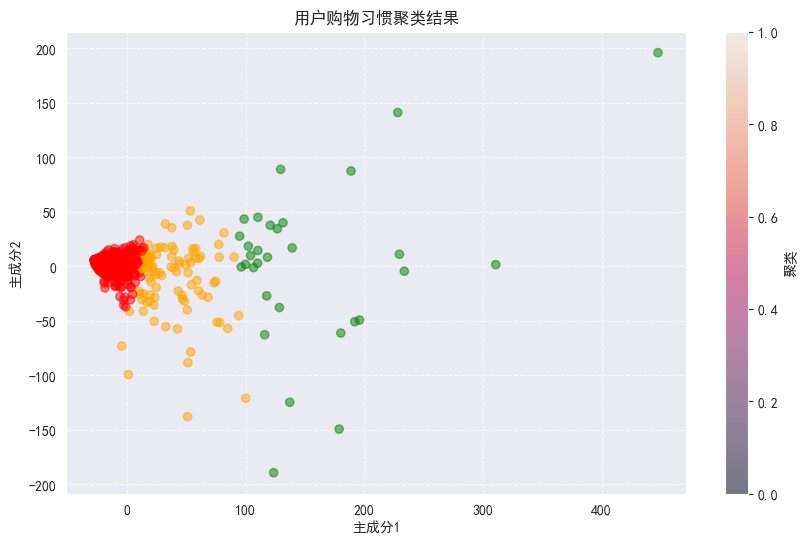

In [20]:
# 给每一个聚簇，涂上颜色
colored = ['orange', 'green','red']
colr = [colored[i] for i in predict]


# 查看聚类结果中有多少个不同的类别，确保聚类的数量与预期一致
print("聚类的类别数量:", len(np.unique(predict)))
print("聚类的类别:", np.unique(predict))


# 可视化聚类结果（取前两个主成分）
plt.figure(figsize=(10, 6))
plt.scatter(user_aisle_pca[:, 0], user_aisle_pca[:, 1], c=colr, cmap='viridis', alpha=0.5)
plt.title("用户购物习惯聚类结果")
plt.xlabel("主成分1")
plt.ylabel("主成分2")
plt.colorbar(label='聚类')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

各类别的用户数量:
KMeans(n_clusters=3)    1
Name: count, dtype: int64
K=2时的轮廓系数: 0.7219
K=3时的轮廓系数: 0.6544
K=4时的轮廓系数: 0.5846
K=5时的轮廓系数: 0.5612
K=6时的轮廓系数: 0.4270
K=7时的轮廓系数: 0.3741
K=8时的轮廓系数: 0.4417
K=9时的轮廓系数: 0.4311


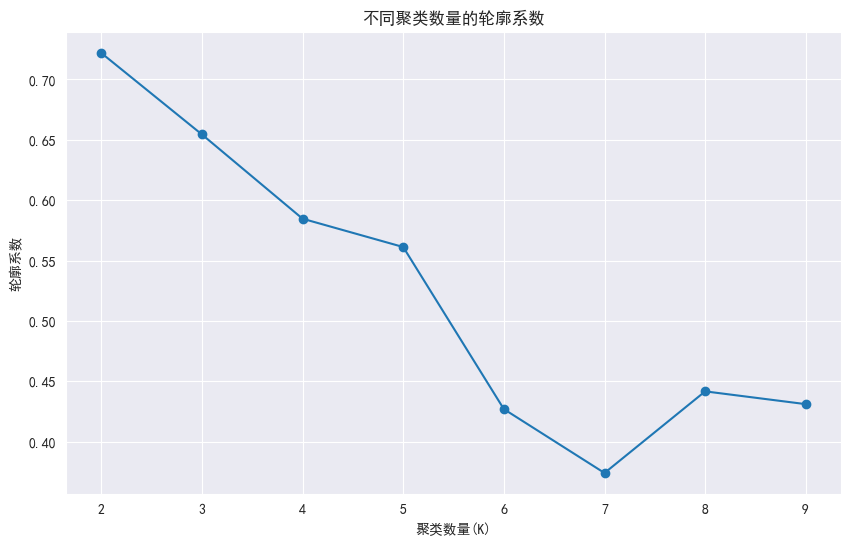

In [21]:
# 统计各类别的用户数量
cluster_counts = pd.Series(clusters).value_counts().sort_index()
print("各类别的用户数量:")
print(cluster_counts)

# 尝试不同的K值，找到最佳聚类数量
silhouette_scores = []
k_range = range(2, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(user_aisle_pca)
    silhouette_avg = silhouette_score(user_aisle_pca, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"K={k}时的轮廓系数: {silhouette_avg:.4f}")

# 绘制轮廓系数随K值变化的曲线
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, 'o-')
plt.title("不同聚类数量的轮廓系数")
plt.xlabel("聚类数量(K)")
plt.ylabel("轮廓系数")
plt.grid(True)
plt.show()

In [25]:
import pandas as pd
# 限制读取的数据量，每个文件只读取前100万行(nrows)
orders = pd.read_csv('../../python_ml/data/instacart/orders.csv', nrows=1000000)
order_products = pd.read_csv('../../python_ml/data/instacart/order_products__prior.csv', nrows=1000000)
products = pd.read_csv('../../python_ml/data/instacart/products.csv', nrows=1000000)
aisles = pd.read_csv('../../python_ml/data/instacart/aisles.csv', nrows=1000000)

# 打印读取的数据行数
print(f"订单数据行数: {len(orders)}")
print(f"订单产品数据行数: {len(order_products)}")
print(f"产品数据行数: {len(products)}")
print(f"货架数据行数: {len(aisles)}")


订单数据行数: 1000000
订单产品数据行数: 1000000
产品数据行数: 49688
货架数据行数: 134
